## STEP 2 - Loan Grade Prediction

In this second step, a machine learning model will be created to predict loan grades (ranging from A to G) from Lending Club's database. This model aims to provide critical insights into borrower creditworthiness, enabling investors and lenders to make informed decisions while reducing risk.

A Lending Club loan grade prediction model can be extremely useful and helpful for Lending Club as a company in several ways:

**1. Risk assessment**: Accurately predicting loan grades can help Lending Club to better assess the risk associated with each loan application, thereby allowing them to make more informed lending decisions, mitigate potential losses, and efficiently allocate their resources.

**2. Pricing**: With a better understanding of each borrower's creditworthiness, Lending Club can set interest rates and loan terms that are more reflective of the potential risk involved, and thus, offer competitive pricing that attracts borrowers while maintaining profitability for investors.

**3. Faster decision-making**: An accurate prediction model can automate the loan grade assignment process, reducing the time spent on manual review and making the loan application process more efficient for both borrowers and lenders.

**4. Enhanced borrower experience**: By quickly and accurately assigning loan grades, Lending Club can provide more personalized loan offers to borrowers, leading to an improved customer experience and higher satisfaction levels.

**5. Attracting investors**: By demonstrating a robust and accurate loan grade prediction model, Lending Club can attract more investors to the platform, providing them with confidence in the company's ability to manage risk and generate positive returns on their investments.

**6. Portfolio diversification**: Accurate loan grade predictions can help Lending Club and its investors diversify their loan portfolios, resulting in a well-balanced mix of low and high-risk loans, which can help to maintain overall stability and minimize losses during economic downturns.

**7. Compliance and transparency**: A data-driven loan grading model can provide transparency into the decision-making process, enabling Lending Club to meet regulatory requirements and build trust with both borrowers and investors.

In summary, a Lending Club loan grade prediction model can lead to better risk management, improved pricing, increased efficiency, enhanced borrower experiences, and higher levels of trust with investors, ultimately driving business growth and long-term success for the company.

#### Imports

In [4]:
import numpy as np
import pandas as pd
import helpers  
import warnings
import pickle
import lightgbm as lgb
  
from sklearn.preprocessing import LabelEncoder 
from joblib import dump
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [5]:
warnings.filterwarnings('ignore')

### Reading the data

First, I start with reading the initial dataset, because this time only accepted dataset will be examined and more its columns.

In [6]:
''' Reading Dataset '''
df_accepted = pd.read_csv("lending-club/accepted.csv")

In [7]:
''' Dropping rows where 'grade' is missing '''
df_accepted = df_accepted[df_accepted.grade.isnull() == False]

Since there are 151 columns in total and 2260668 rows, I will remove those columns which have more than 95% of the data missing.

In [8]:
''' Printing out number of columns and rows in the dataset'''
f"Number of columns - {len(df_accepted.columns)}, number of rows {len(df_accepted)}"

'Number of columns - 151, number of rows 2260668'

In [9]:
''' Removing those columns with large percentage of data missing '''
cols_to_remove = helpers.get_cols_with_large_missing_vals(df_accepted)

id column also seems to be useless, therefore, it will be added to cols_to_remove as well

In [10]:
''' Adding id to useless columns '''
cols_to_remove = list(cols_to_remove.keys())
cols_to_remove.append("id")

In [11]:
''' Dropping useless columns'''
df_accepted = df_accepted.drop(cols_to_remove, axis=1)

There are many more useless columns in the dataset. Such as url, zip code, payment plan and similar which do not give meaningful information about loan applicant.

In [12]:
''' Creating list of more useless columns '''
more_useless_cols = ['url', 'pymnt_plan', 'title', 'zip_code',
                     'last_pymnt_d', 'debt_settlement_flag',
                     'issue_d', 'last_credit_pull_d', 'earliest_cr_line',
                     'sec_app_earliest_cr_line', 'next_pymnt_d']

In [13]:
''' Dropping useless columns '''
df_accepted = df_accepted.drop(more_useless_cols, axis=1)

### Data Exploration

#### About Loan Grade
The **loan grades** in Lending Club are determined before the loan is accepted by investors. Lending Club uses a proprietary credit model to assign grades to loans based on factors such as credit history, income, employment status, and loan amount. The grades range from A to G, with A being the least risky and G being the most risky. Once a loan is graded, it is made available for investors to fund. The loan grades do not change after the loan is accepted or after the first installment is made.

Target Features:
* **grade**
* **subgrade**
* **int_rate**

Set only afert knowing loan grade (Data Leakage):
* **installment**: refers to the periodic payment you make to repay your loan over time.
* **chargeoff_within_12_mths**, **sec_app_chargeoff_within_12_mths**: this feature may represent data leakage because it reflects the outcome of the loan, which is not known at the time of loan application.
* **delinq_2yrs**, **inq_last_6mths**, **mths_since_last_delinq**, **mths_since_last_record**, **pub_rec**, **pub_rec_bankruptcies** **collections_12_mths_ex_med**, **sec_app_collections_12_mths_ex_med**, **mths_since_last_major_derog**, **sec_app_mths_since_last_major_derog**, **acc_now_delinq**, **delinq_amnt**, **num_accts_ever_120_pd**, **num_tl_30dpd**, **num_tl_90g_dpd_24m**, **sec_app_inq_last_6mths**: These variables relate to the borrower's credit history and may be useful for predicting loan grade, but they could also be considered part of the outcome (default) and therefore cause data leakage. Some of these features may indeed be correlated with the outcome (i.e., whether or not the borrower will default on the loan), but they are not considered part of the outcome itself. Rather, they are additional pieces of information about the borrower that the lender may use to assess their creditworthiness and determine whether to approve the loan and at what interest rate.
* **total_pymnt**, **total_pymnt_inv**, **total_rec_prncp**, **total_rec_int**, **total_rec_late_fee**, **recoveries**, **collection_recovery_fee**: These variables are related to payments made by the borrower after the loan has been issued, and would not be known at the time the loan grade is assigned.
* **last_pymnt_amnt**, **last_credit_pull_d**, **last_fico_range_high**, **last_fico_range_low**: These variables are related to payments made by the borrower after the loan has been issued, and would not be known at the time the loan grade is assigned.
* **funded_amnt** and **funded_amnt_inv**: set only after issuing loan 
* **hardship_flag** indicates whether the borrower has requested a hardship plan due to financial difficulties that affect their ability to make payments on time. This is usually set after the loan is issued and the borrower requests a hardship plan.
* **disbursement_method** specifies how the borrower received the funds from the loan. This is typically set after the loan is approved and the borrower agrees to the terms of the loan, and before the funds are disbursed.
* **loan_status**: This is the current status of the loan, such as "Current", "Fully Paid", "Late (16-30 days)", "Charged Off", etc. This information is not available until after the loan has been issued.
* **out_prncp**: This is the remaining outstanding principal balance on the loan. It is updated as the borrower makes payments on the loan.
* **out_prncp_inv**: This is the remaining outstanding principal balance on the loan that is held by investors. Like out_prncp, it is updated as the borrower makes payments on the loan.
* **mths_since_rcnt_il**, **mths_since_recent_bc**, **mths_since_recent_bc_dlq**, and **mths_since_recent_inq** all measure the number of months since the borrower's most recent installment loan, recent bankcard account, recent bankcard delinquency, and recent inquiry, respectively. These values would not be available at the time of loan grade determination because they require time to accumulate.
* **open_acc_6m**, **open_act_il**, **sec_app_open_act_il**, **open_il_12m**, **open_il_24m**, **total_bal_il**, and **il_util** all depend on the borrower's current credit utilization and account status, which can change over time. These values would not be available at the time of loan grade determination because they could be different at the time of application versus the time of loan grade determination.
* **policy_code**: This feature is always equal to 1 and provides no useful information for predicting loan grade.
* **revol_util** and **sec_app_revol_util**: The revol_util value in the loan data refers to the revolving line utilization rate at the time the loan was issued, so it is included for the new loan. Therefore, it won't be useful to set loan grade.
* **revol_bal_joint**: set at the time the loan is issued. This feature represents the total revolving balance on all accounts at the time the borrower applied for the loan, including both the borrower and any co-borrowers or joint account holders. 


Not useful:
* **emp_title**: credit information of user would be more important than employment title.
* **desc**: This variable contains free-form text entered by the borrower, and may not be useful for predicting loan grade. **Purpose** will be more useful.
* **issue_d**: This variable is the date the loan was issued and would not be useful for predicting loan grade.
* **initial_list_status**: This variable is related to how the loan was listed on Lending Club's platform and may not be useful for predicting loan grade.
* **inq_fi** or **open_rv_12m** may not be very relevant in predicting loan grade or default risk. These features may provide additional information, but they may not be as important as other features in the dataset.
* **application_type**: this feature indicates whether the loan application was made by an individual borrower or a joint application with another person.

In [14]:
''' Creating list of not useful or columns that are data leakage '''
drop_cols = ['desc', 'issue_d', 'revol_util',  'sec_app_revol_util', 'initial_list_status', 'installment', 'chargeoff_within_12_mths', 'sec_app_chargeoff_within_12_mths', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'pub_rec', 'pub_rec_bankruptcies', 'collections_12_mths_ex_med', 'sec_app_collections_12_mths_ex_med', 'mths_since_last_major_derog', 'sec_app_mths_since_last_major_derog', 'acc_now_delinq', 'delinq_amnt', 'num_accts_ever_120_pd', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'sec_app_inq_last_6mths', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'addr_state', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'disbursement_method', 'loan_status', 'out_prncp', 'out_prncp_inv', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'open_acc_6m', 'open_act_il', 'sec_app_open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'il_util', 'policy_code']

Since there are columns that have a small number of missing values, I'll simply drop those rows.

In [15]:
''' Dropping rows of columns that have less or equal 200 missing values'''
df_accepted = helpers.drop_nan_small_missing_cols(df_accepted, num=200)

The goal of step 2 is to predict grade, therefore, it is important to remove data leakage columns that won't be present at the time of grade prediction

In [16]:
''' Creating targets list '''
targets = ['grade', 'sub_grade', 'int_rate']

In [17]:
''' Dropping useless columns '''
df_accepted = df_accepted[[col for col in df_accepted.columns if col not in drop_cols]]

Since there are both individual and joint applications in the dataset, I'll first remove rows that are not complete. For instance:

* individual applications that have some "joint" values"
* joint applications that have some joint values missing

In [18]:
''' Creating individual loans dataset '''
df_individual = df_accepted[(df_accepted['verification_status_joint'].isnull() == True) & 
                            (df_accepted['dti_joint'].isnull() == True) &
                            (df_accepted['sec_app_open_acc'].isnull() == True) &
                            (df_accepted['sec_app_fico_range_low'].isnull() == True) &
                            (df_accepted['sec_app_fico_range_high'].isnull() == True) & 
                            (df_accepted['annual_inc_joint'].isnull() == True)]

In [19]:
''' Creating join loans dataset '''
df_joint = df_accepted[(df_accepted['verification_status_joint'].isnull() == False) & 
                       (df_accepted['dti_joint'].isnull() == False) &
                       (df_accepted['sec_app_open_acc'].isnull() == False) &
                       (df_accepted['sec_app_fico_range_low'].isnull() == False) &
                       (df_accepted['sec_app_fico_range_high'].isnull() == False) & 
                       (df_accepted['annual_inc_joint'].isnull() == False)]

In [20]:
''' Updating df_accepted with only joint and individual loans '''
df_accepted = pd.concat([df_joint, df_individual], ignore_index=True)

There are quite a few outliers in the dataset, thus removing them is necessary. I'll remove outliers from large numerical columns and from columns that have a meaningful information about applicant creditworthiness such as annual income, dti, fico ranges and important loan value - loan_amount

In [21]:
''' Removing outliers '''
df_accepted = helpers.remove_num_outliers(df_accepted, nunique=100000, thres=0.99)

In [22]:
''' Removing outliers from important features '''
df_test = df_accepted.copy()
df_test = helpers.remove_outliers_col(df_test, "loan_amnt", 0.95)
df_test = helpers.remove_outliers_col(df_test, "annual_inc", 0.95)
df_test = helpers.remove_outliers_col(df_test, "dti", 0.95)
df_test = helpers.remove_outliers_col(df_test, "fico_range_high", 0.95)
df_test = helpers.remove_outliers_col(df_test, "fico_range_low", 0.95)

We can see that the columns 'loan_amnt', 'annual_inc', 'dti', 'fico_range_high', 'fico_range_low' distributions have changed after removing outliers. Especially, dti and annual_inc which had the most outliers.

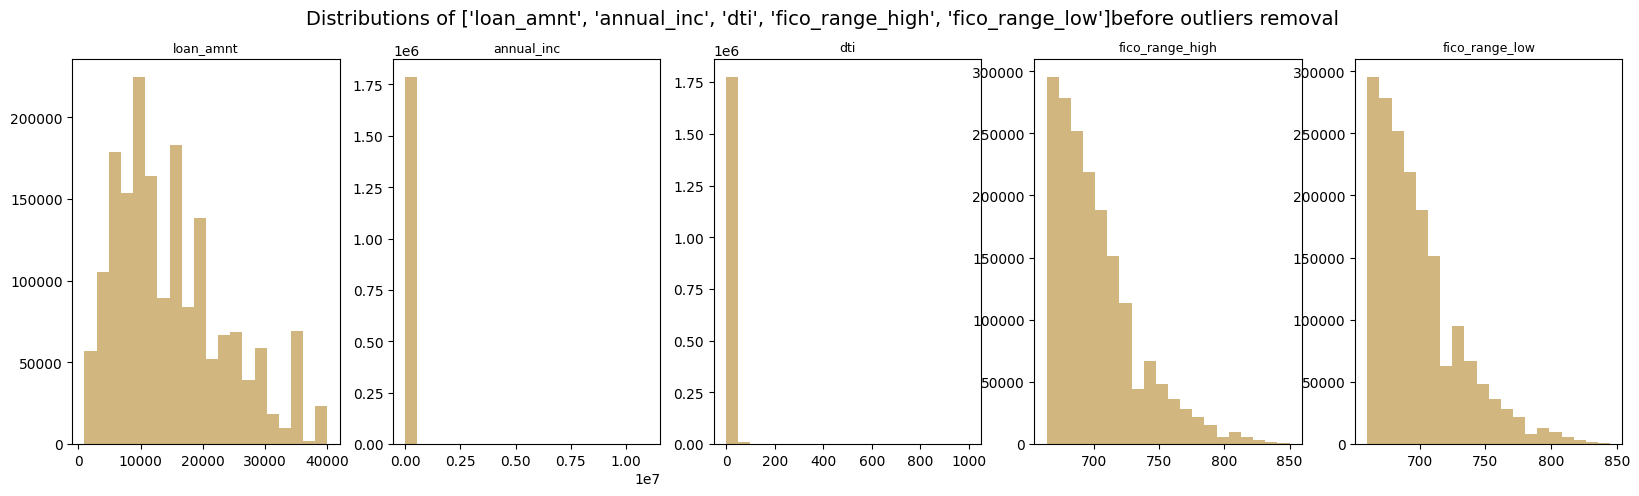

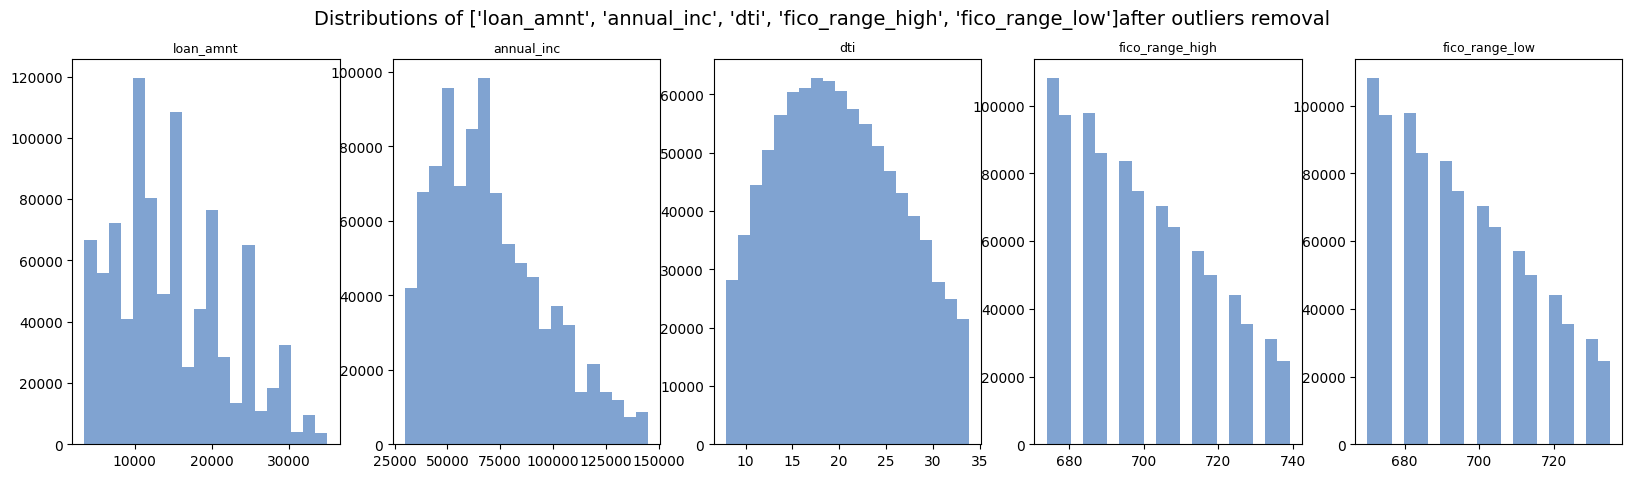

In [23]:
''' Plotting values with and without outliers '''
helpers.plot_hist_distributions(df_accepted, ['loan_amnt', 'annual_inc', 'dti', 'fico_range_high', 'fico_range_low'], color="#d1b680", desc="before outliers removal")
helpers.plot_hist_distributions(df_test, ['loan_amnt', 'annual_inc', 'dti', 'fico_range_high', 'fico_range_low'], color="#80a3d1", desc="after outliers removal")

We can see the distribution of loan grade classes. There are most loans with grade B and least with G.

In [24]:
''' Updating df_accepted without outliers '''
df_accepted = df_test.copy()
df_accepted.grade.value_counts()

B    290096
C    280163
A    152280
D    128924
E     52576
F     15976
G      4460
Name: grade, dtype: int64

### Feature Engineering and Selection

#### Taking Stratified Split 

First, I wanted to take a sample of the dataset with each grade having the same number of rows. For this I'll use a stratified_sample function which is defined in helpers.py

In [25]:
''' Taking a stratified sample for each grade'''
df_stratified_sample = helpers.stratified_sample(df_accepted, 'grade')

We can see that after taking a sample, there have been left 1061 rows of each grade. Therefore, in total we will have 1061 entries for each grade.

In [26]:
''' Displaying number of rows for each frade'''
df_stratified_sample.grade.value_counts()

B    4460
A    4460
E    4460
D    4460
C    4460
F    4460
G    4460
Name: grade, dtype: int64

Since employment title does not seem to give meaningful information about client's credit worthiness, I'll drop this column as well.

In [27]:
''' Removing emp_title column '''
df_accepted_step2 = df_stratified_sample.copy()
df_accepted_step2 = df_accepted_step2.drop(['emp_title'], axis=1)

In [28]:
''' Encoding grade into numeric value '''
encoder = LabelEncoder()
encoder.fit(df_accepted_step2['grade'])
df_accepted_step2['grade'] = encoder.transform(df_accepted_step2['grade']) 

In [29]:
''' Taking separate dataframe for containing columns '''
df_step2_targets = df_accepted_step2[targets] 

In [30]:
''' Removing target values from dataframe '''
feature_cols = [col for col in df_accepted_step2.columns if col not in drop_cols]
df_accepted_step2 = df_accepted_step2[[col for col in feature_cols if col not in targets]]

#### Mutual Information

Since there are both individual and joint columns, creating mutual information scores might have false importance scores. Therefore, I'll perform mutual information for joint columns and not joint application columns separately and then will choose only feature that have highest score.

##### MI scores for NOT joint columns

In [31]:
''' Taking a list of columns that are from joint applications '''
joint_cols = list( set([col for col in df_accepted_step2.columns if "sec" in col or "joint" in col]))
common_not_joint_cols = [col for col in df_accepted_step2.columns if not ("sec" in col or "joint" in col) and any(col in joint_col for joint_col in joint_cols)]
all_common_cols = joint_cols + common_not_joint_cols

In the plot below, we can see which features are the most important with target variable grade. Term has the strongest score, then it goes loan amount, all_util, bc_open_to_buy and so on. There are quite a few less meaningful or not meaningful columns at all. Thefore, I'll drop those who have smaller than 0.01 score.

term                    0.204197
loan_amnt               0.108708
acc_open_past_24mths    0.050125
inq_last_12m            0.049785
num_tl_op_past_12m      0.044558
all_util                0.042000
purpose                 0.039788
bc_open_to_buy          0.032559
num_actv_bc_tl          0.028830
inq_fi                  0.027047
open_rv_24m             0.024405
open_rv_12m             0.022097
mo_sin_rcnt_tl          0.022046
num_tl_120dpd_2m        0.021529
max_bal_bc              0.021184
pct_tl_nvr_dlq          0.019860
percent_bc_gt_75        0.019460
total_cu_tl             0.010927
total_rev_hi_lim        0.009597
total_bal_ex_mort       0.008343
Name: MI Scores, dtype: float64


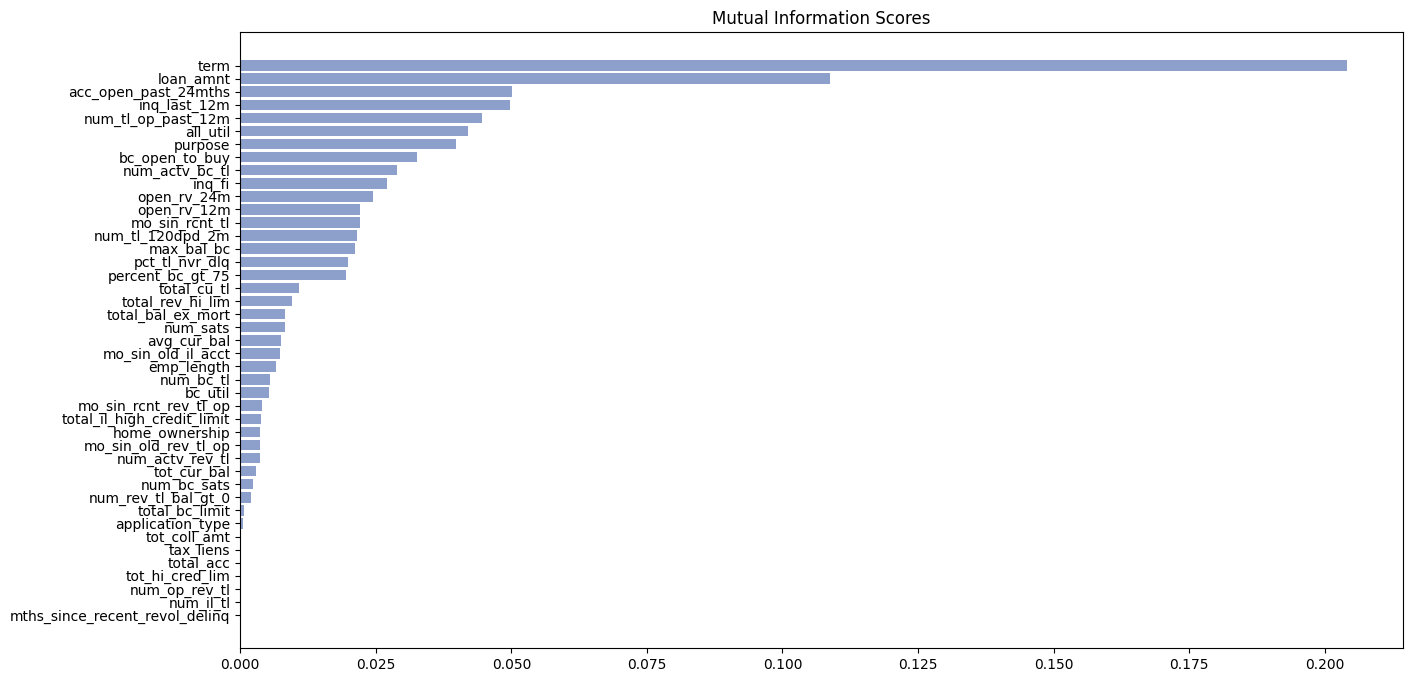

In [32]:
''' Getting mutal information values for numerical values '''
mi_scores = helpers.get_and_plot_mi_scores(df_accepted_step2[[col for col in df_accepted_step2.columns if col not in all_common_cols]].copy(),
                                           df_step2_targets, 'grade')

In [33]:
''' Dropping meaningless columns '''
df_accepted_step2 = df_accepted_step2[helpers.get_best_cols_from_mi_scores(mi_scores, df_accepted_step2.copy(), 0.01)]

##### MI scores for JOINT columns

Now I'll do the same for joint columns. We can see that fico range and dti values are the most important. But there are also a lot not useful columns, which I'll drop as well.

sec_app_fico_range_low       0.123280
fico_range_low               0.120606
fico_range_high              0.114320
sec_app_fico_range_high      0.084456
verification_status          0.052825
dti                          0.043549
verification_status_joint    0.040641
dti_joint                    0.028733
revol_bal                    0.020569
mort_acc                     0.016322
annual_inc                   0.011501
annual_inc_joint             0.008299
revol_bal_joint              0.006659
sec_app_num_rev_accts        0.002280
open_acc                     0.000000
sec_app_mort_acc             0.000000
sec_app_open_acc             0.000000
num_rev_accts                0.000000
Name: MI Scores, dtype: float64


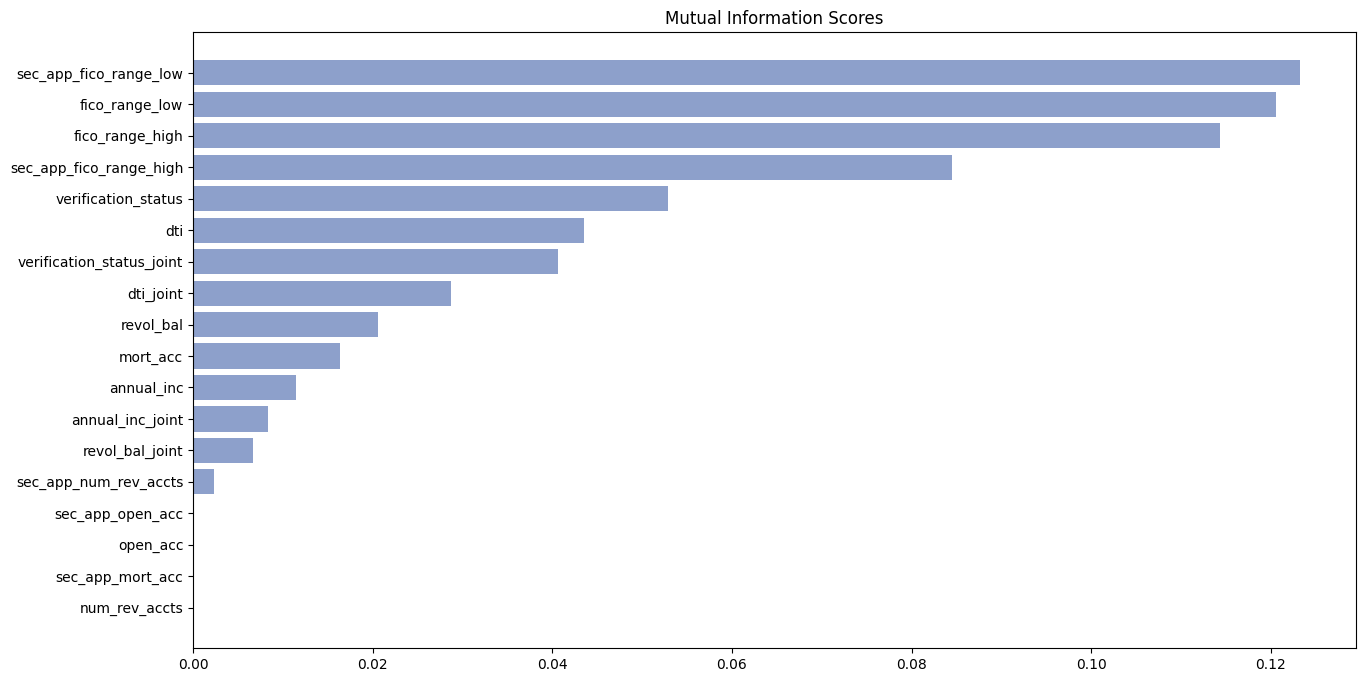

In [34]:
''' Getting mutal information values for numerical values  '''
mi_scores_joint = helpers.get_and_plot_mi_scores(df_accepted_step2[all_common_cols].copy(),
                                                 df_step2_targets, 'grade')

In [35]:
''' Getting columns to pdrop that have smaller than 0.01 mutual information score '''
useless_joint_cols = helpers.get_useless_joint_cols(mi_scores_joint, common_not_joint_cols, joint_cols, 0.01)

In [36]:
''' Dropping those useless columns '''
df_accepted_step2 = df_accepted_step2.drop(useless_joint_cols, axis=1)

#### Creating New Features

The code creates several new columns in the dataframe df_accepted_step4 with different purposes:

* **fico_avg**: This column calculates the average FICO score range for each loan application based on the high and low FICO score ranges provided in the dataset.

* **sec_app_fico_avg**: This column calculates the average FICO score range for joint loan applications where a second applicant's FICO score is available.

* **fico_diff**: This column calculates the difference between the high and low FICO score ranges provided for each loan application.

* **sec_app_fico_diff**: This column calculates the difference between the high and low FICO score ranges for joint loan applications where a second applicant's FICO score is available.

* **loan_size_category**: This column categorizes each loan application into six categories based on the loan amount: < 5K, 5K - 10K, 10K - 20K, 20K - 30K, 30K - 40K, and >= 40K.

In [37]:
''' Create a new column for the FICO score range average '''
df_accepted_step2['fico_avg'] = df_accepted_step2[['fico_range_high', 'fico_range_low']].apply(lambda x: x.mean(), axis=1)

In [38]:
''' Create a new column for the FICO Difference ''' 
df_accepted_step2['sec_app_fico_avg'] = df_accepted_step2[['sec_app_fico_range_high', 'sec_app_fico_range_low']].apply(lambda x: x.mean(), axis=1)

In [39]:
''' Create a new column for the FICO Difference ''' 
df_accepted_step2['fico_diff'] = df_accepted_step2['fico_range_high'] - df_accepted_step2['fico_range_low']

In [40]:
''' Create a new column for the FICO Difference ''' 
df_accepted_step2['sec_app_fico_diff'] = df_accepted_step2['sec_app_fico_range_high'] - df_accepted_step2['sec_app_fico_range_low']

In [41]:
'''Create a new column for the Loan Size Category '''
bins = [0, 5000, 10000, 20000, 30000, 40000, float('inf')]
labels = ['< 5K', '5K - 10K', '10K - 20K', '20K - 30K', '30K - 40K', '>= 40K']
df_accepted_step2['loan_size_category'] = pd.cut(df_accepted_step2['loan_amnt'], bins=bins, labels=labels)

##### Dropping too correlated columns

Dropping highly correlated columns is useful for machine learning because it can improve model performance by reducing multicollinearity, making the model more accurate and easier to interpret. It can also reduce the risk of overfitting and simplify the model, making it easier to train and deploy.

Therefore, I'll drop the columns that have too strong correlations with each other but will leave one of them which has higher mi score with grade value.

In [42]:
''' Taking features that are too correlated with one another '''
to_drop = helpers.get_too_correlated_cols_and_print_pairs(df_accepted_step2, all_common_cols, mi_scores)

There are no too correlated


In [43]:
''' Dropping too correlated columns '''
df_accepted_step2 = df_accepted_step2.drop(to_drop, axis=1)

However, there were no too correlated features, therefore there is nothing to drop.

##### Converting term and emp_length into ordinal values

Term and emp_length can be considered as ordinal values, therefore I'll convert them into numbers.

In [44]:
''' If term is not dropped, convert it to numerical value '''
if "term" in df_accepted_step2.columns:
    df_accepted_step2['term'] = df_accepted_step2['term'].map({" 36 months": 36, " 60 months": 60})

In [45]:
''' If emp_length is not dropped, convert it to numerical value '''
if "emp_length" in df_accepted_step2.columns:
    df_accepted_step2['emp_length'] = df_accepted_step2['emp_length'].map({"< 1 year": 0, "1 year": 1,
                                                                            "2 years": 2, "3 years": 3,
                                                                            "4 years": 4, "5 years": 5,
                                                                            "6 years": 6, "7 years": 7,
                                                                            "8 years": 8, "9 years": 9, "10+ years":10})

### Principal Component Analysis (PCA)

In [46]:
''' Taking joint columns into a list '''
joint_cols = set([col for col in df_accepted_step2.columns if "sec" in col or "joint" in col])
joint_num_cols = [col for col in joint_cols if df_accepted_step2[col].dtype != "object"]
joint_cat_cols = [col for col in joint_cols if df_accepted_step2[col].dtype == "object"]

In [47]:
''' Taking numerical and categorical features '''
numerical_features = df_accepted_step2.select_dtypes(include=[np.number]).columns.tolist() 
cat_features = df_accepted_step2.select_dtypes(include=['object', pd.api.types.CategoricalDtype]).columns.tolist()

In [48]:
''' Taking numerical, ordinal and other categorical values '''
num_cols = [col for col in numerical_features if col not in joint_cols]
ord_cols = [col for col in df_accepted_step2.columns if col in ['term', 'emp_length']]
ohec_cols = [col for col in df_accepted_step2.columns if col in cat_features and col not in ord_cols and col not in joint_cat_cols]

#### Train, test, validation sets

Splitting data into training, validation, and testing sets is important to avoid overfitting, evaluate model performance, tune model parameters, and prevent data leakage. It helps ensure the model generalizes well to new, unseen data and provides an unbiased estimate of its performance.

I'll split this data into train, test and validation by stratifying it with target value "grade"

In [49]:
''' Splitting dataset into train and validation '''
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(df_accepted_step2, df_step2_targets, 'grade')

In [50]:
''' Creating preprocessor and fitting on training data'''
preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy())
X_train_transformed = preprocessor.fit_transform(X_train)

Number of components to keep: 24


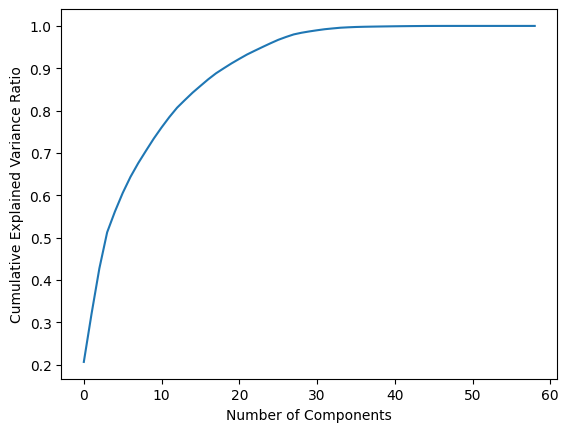

In [51]:
''' Plotting elbow plot and getting n_components'''
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.95)

In [52]:
''' Getting ipca value '''
_, ipca = helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.20626409 0.11436944 0.10659093 0.08521755 0.04899809 0.04384539
 0.03806282 0.03256666 0.0293422  0.02869492 0.02619057 0.02451158
 0.02225919 0.01802001 0.01754753 0.01577047 0.01555879 0.01416076
 0.01190152 0.01158764 0.01067543 0.01033882 0.00896291 0.00879616]


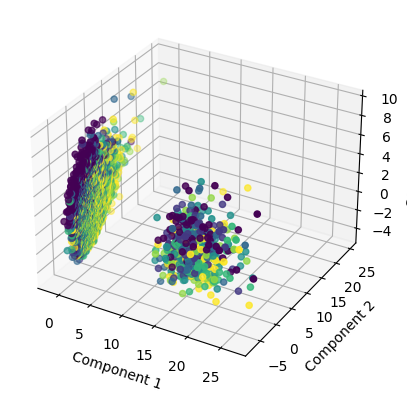

In [53]:
''' Plotting the 3 PCAs '''
helpers.plot_3_pcas(ipca, X_train_transformed, y_train)

Since, my plan is to use different types of models, I don't want to use one hot encoding for tree based models, therefore, I'll calculate the number of components for such preprocessor as well.

In [54]:
''' Creating preprocessor and fitting on training data for tree based models '''
tree_preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy(), 'tree')
X_train_transformed = tree_preprocessor.fit_transform(X_train)

Number of components to keep: 22


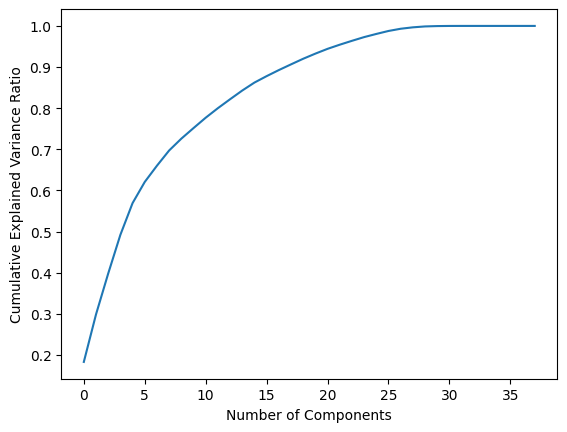

In [55]:
''' Plotting elbow plot and getting n_components for tree based models '''
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.95)

In [56]:
''' Getting ipca value for tree based models '''
_, tree_ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.1832246  0.11552626 0.09933101 0.09413875 0.07706699 0.0514499
 0.03945339 0.03699696 0.02873616 0.02571667 0.02521278 0.02316164
 0.02171693 0.0211923  0.0193497  0.01561878 0.01471844 0.01386915
 0.01362378 0.01246928 0.01161818 0.00986355]


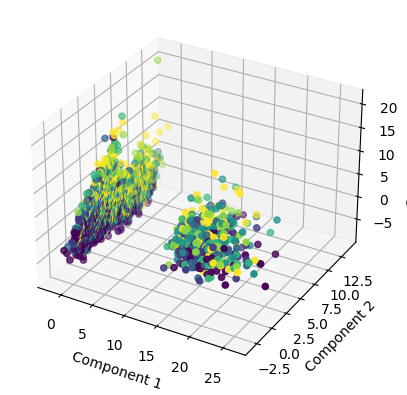

In [57]:
''' Plotting the 3 PCAs for tree based models'''
helpers.plot_3_pcas(tree_ipca, X_train_transformed, y_train)

### Grade Prediction Part

The F1 score is a measure that combines precision and recall into a single value and is often used to evaluate the performance of binary classification models. In the case of predicting loan grade for the Lending Club dataset, the F1 score can be useful because it takes into account both the number of true positives (i.e., correctly predicted loan grades) and false positives (i.e., loans that were predicted to have a certain grade but actually did not).

The F1 score can be especially useful in this context because precision and recall alone may not provide a complete picture of the model's performance. For example, if a model has high precision but low recall, it may be accurately predicting loan grades for only a small number of loans, while missing many others. On the other hand, if a model has high recall but low precision, it may be identifying a large number of loans as having a certain grade, but many of those predictions may be incorrect.

By combining precision and recall, the F1 score provides a more balanced measure of the model's performance. This can help lenders make more informed decisions about which loans to approve and which to reject, based on the predicted loan grade.

In [58]:
''' Creating list of models - tree based models and other type of models '''
tree_models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(), 
    ExtraTreesClassifier(),
    XGBClassifier(),
    lgb.LGBMClassifier(),
    DecisionTreeClassifier()
]

other_models = [
    LogisticRegression(),  
    KNeighborsClassifier(),
    GaussianNB(),
    BernoulliNB(),
    QuadraticDiscriminantAnalysis()
]

In [59]:
''' Creating list of pipelines with preprocessor ''' 
pipelines = helpers.getting_pipelines(tree_models, tree_preprocessor, tree_ipca, other_models, preprocessor, ipca)

First, I run the models and we can see top 3 best models for predicting grade:

* **LGBMClassifier** with f1 score of 0.338
* **GradientBoostingClassifier** with f1 score of 0.336
* **XGBClassifier** with f1 score of 0.333
* **LogisticRegression** with f1 score of 0.327
* **RandomForestClassifier** with f1 score of 0.324

The f1 scores are not very high but maybe hyper parameter tuning might help with this.

In [60]:
''' Printing out results of tested models '''
print("The best performing models are:") 
models_results = helpers.try_models(pipelines, X_train, y_train, X_val, y_val)
models_results.iloc[:, 1:]

The best performing models are:


,model_name,f1_score,recall_score,precision_score
5,LGBMClassifier,0.338870,0.348078,0.334528
1,GradientBoostingClassifier,0.336763,0.347878,0.333015
4,XGBClassifier,0.333701,0.339672,0.329973
7,LogisticRegression,0.327606,0.342274,0.323161
0,RandomForestClassifier,0.324817,0.335869,0.319820
2,AdaBoostClassifier,0.313846,0.327462,0.310251
3,ExtraTreesClassifier,0.310040,0.324259,0.303717
8,KNeighborsClassifier,0.275030,0.284828,0.272288
10,BernoulliNB,0.266661,0.284828,0.263845
6,DecisionTreeClassifier,0.248091,0.248599,0.247745


Now I'll perform hyperparameter tuning on these top 3 models.

In [62]:
''' Perform optuna tuning '''
results = helpers.optuna_tuning(helpers.objective, models_results.head(4).copy(), X_train, y_train, X_val, y_val)

Tuned LGBMClassifier:


,f1_score,num_leaves,learning_rate,max_depth,min_child_samples,subsample,colsample_bytree
0,0.346634,6,0.220748,5,67,0.142364,0.899427


Tuned GradientBoostingClassifier:


,f1_score,max_depth,learning_rate,min_samples_split,min_samples_leaf,subsample,max_features
0,0.342997,17,0.022796,78,23,0.338249,0.505009


Tuned XGBClassifier:


,f1_score,max_depth,learning_rate,min_child_weight,subsample,colsample_bytree,gamma,alpha,lambda
0,0.346935,16,0.125528,66,0.252162,0.862264,0.018614,0.003269,0.002614


Tuned LogisticRegression:


,f1_score,penalty,C,solver
0,0.330606,l2,646.736659,lbfgs


However, the results did not become very higher after performing tuning but it still helped.

In [70]:
''' Printing out top 3 models f1 scores '''
final_model_results = dict(sorted(results.items(), key=lambda item: item[1]['f1_score'], reverse=True))
dict(sorted({model[1]: result['f1_score'] for model, result in results.items()}.items(), key=lambda item: item[1], reverse=True))

{'XGBClassifier': 0.34693499027681823,
 'LGBMClassifier': 0.3466335676922852,
 'GradientBoostingClassifier': 0.3429972173226032,
 'LogisticRegression': 0.3306063854509919}

In [71]:
''' Getting list of final top 3 models '''
final_top_models = [pipeline[0] for pipeline in list(final_model_results.keys())][:3]

**Cross Validation**

Now I'll perform cross validation to see how well our models are generalizing and how it behaves on new data compared with cross validated train data.

In [72]:
''' Getting predictions of top 3 models and performing cross validation '''
scores, predictions = helpers.perform_cross_validation(final_top_models, X_train, y_train, X_val, y_val, score='f1_score')

------------------------- XGBClassifier -------------------------
TRAIN DATA (cross validated) f1_score is 0.345
VALIDATION DATA - f1_score for the XGBClassifier model is: 0.347

------------------------- LGBMClassifier -------------------------
TRAIN DATA (cross validated) f1_score is 0.348
VALIDATION DATA - f1_score for the LGBMClassifier model is: 0.347

------------------------- GradientBoostingClassifier -------------------------
TRAIN DATA (cross validated) f1_score is 0.343
VALIDATION DATA - f1_score for the GradientBoostingClassifier model is: 0.343



All of these three models behave are very similar. They are all tree based models, thus the results are also quite similar. Therefore, I will choose one which has the highest precision. 

The precision values are also quite similar, but we see the highest score for XGBClassifier model, therefore I will take this one as the final model.

In [78]:
''' Displaying precision values on top 3 models '''
print(f"{type(list(predictions.keys())[0].named_steps['model']).__name__} precision value - {metrics.precision_score(y_val, list(predictions.values())[0], average='weighted')}")
print(f"{type(list(predictions.keys())[1].named_steps['model']).__name__} precision value - {metrics.precision_score(y_val, list(predictions.values())[1], average='weighted')}")
print(f"{type(list(predictions.keys())[2].named_steps['model']).__name__} precision value - {metrics.precision_score(y_val, list(predictions.values())[2], average='weighted')}")

XGBClassifier precision value - 0.3428108698400598
LGBMClassifier precision value - 0.3420241968784509
GradientBoostingClassifier precision value - 0.3381086179674184


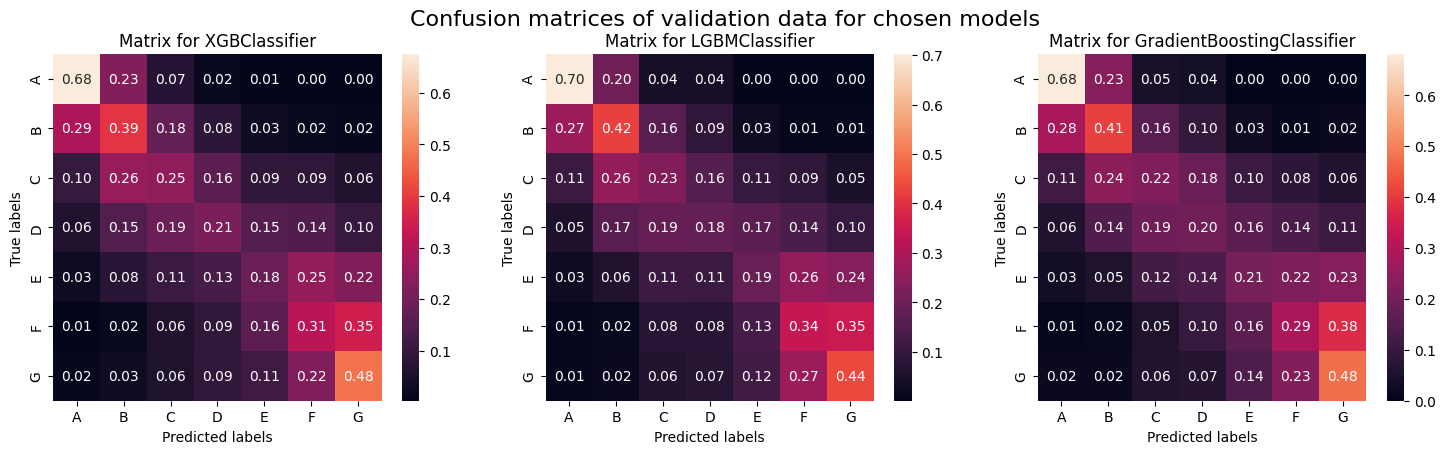

In [81]:
''' Plotting confusion matrices of top 3 models'''
helpers.plot_conf_matrices(predictions, y_val, ["A", "B", "C", "D", "E", "F", "G"])

However even though XGBClassifier is the best one, it is still not very good. 
 
Based on the normalized confusion matrix for an XGBoost classifier, we can see that the diagonal values represent the proportion of correctly predicted labels. From the diagonal, we can see that class G is being predicted the best with 34.87% of true G labels being correctly predicted as G. Class A is also being predicted fairly well with 68% of true A labels being correctly predicted as A.

The worst predicted class seems to be F, as only 18.49% of true F labels are being correctly predicted as F. Class E is also being predicted poorly with only 18.49% of true E labels being correctly predicted as E.

Overall, the model seems to be struggling with predicting lower grades (F and E) and is better at predicting higher grades (A and G). Further analysis and improvements might be required to enhance the model's performance.

Now I will extract the best model with highest f1_score and then save it into joblib file in order to deploy it an app.

In [82]:
''' Extracting the best model '''
best_model = list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.keys())[0]
f"Best model for grade prediction - {type(best_model.named_steps['model']).__name__}"

'Best model for grade prediction - XGBClassifier'

In [83]:
''' Deploy model into joblib file '''
dump(best_model, "step2-grade_classifier.joblib")

['step2-grade_classifier.joblib']

## STEP 3 - Loan Subgrade Prediction

Step 3 of the project involves creating a machine learning model to predict loan subgrades from Lending Club's database. Loan subgrades are more specific categories within each loan grade (ranging from A1 to G5) and are represented by values such as E4, C1, B5, etc.

Predicting loan subgrades accurately can provide even more granular insights into borrower creditworthiness, allowing for better risk assessment and pricing decisions by Lending Club. This can further enhance the borrower experience by providing more tailored loan offers based on their creditworthiness.

In addition, a loan subgrade prediction model can help with portfolio diversification, allowing Lending Club and its investors to allocate their resources efficiently across a wide range of loans, from low-risk to high-risk, and minimize losses during economic downturns.

Furthermore, compliance and transparency can be achieved through a data-driven loan subgrading model, which can provide insights into the decision-making process and meet regulatory requirements.

Overall, the loan subgrade prediction model can provide valuable insights and benefits to Lending Club, including better risk management, improved pricing, increased efficiency, enhanced borrower experiences, and higher levels of trust with investors, ultimately driving business growth and long-term success for the company.

I begin with taking startified sample, but this time I stratify based on sub_grade value

In [131]:
''' Taking a stratified sample for each grade'''
df_accepted_step3 = helpers.stratified_sample(df_accepted, 'sub_grade') 

In [132]:
''' Dropping emp ttle column '''
df_accepted_step3 = df_accepted_step3.drop(['emp_title'], axis=1)

We can see that now we have equal sizes of each subgrade class (652), totaling the size of the dataframe to be 22820

In [133]:
''' Displaying the number of each sub grade class '''
df_accepted_step3.sub_grade.value_counts()[:5]

B5    573
F1    573
C5    573
E5    573
F2    573
Name: sub_grade, dtype: int64

Since step 3 is to predict subgrade, we can now use grade as a feature. However, interest rate still leaves out to be a target for step 4, therefore, I add it to the targets dataframe as well.

In [134]:
''' Separating sub grade and interest rate as target values '''
df_step3_targets = df_accepted_step3[['sub_grade', "int_rate"]]

In [135]:
''' Removing target values from the dataset '''
feature_cols = [col for col in df_accepted_step3.columns if col not in drop_cols]
df_accepted_step3 = df_accepted_step3[[col for col in feature_cols if col not in targets or col == "grade"]]

In [136]:
''' Encoding sub grade into numerical value '''
encoder = LabelEncoder()
encoder.fit(df_step3_targets['sub_grade'])
df_step3_targets['sub_grade'] = encoder.transform(df_step3_targets['sub_grade']) 

### Feature Selection

#### Mutual Information

##### MI scores for NOT joint columns

In [137]:
''' Taking a list of columns that are from joint applications '''
joint_cols = list( set([col for col in df_accepted_step3.columns if "sec" in col or "joint" in col]))
common_not_joint_cols = [col for col in df_accepted_step3.columns if not ("sec" in col or "joint" in col) and any(col in joint_col for joint_col in joint_cols)]
all_common_cols = joint_cols + common_not_joint_cols

In the plot below, we can see which features are the most important with target variable subgrade. 

As expected, grade is the strongest value here since subgrade is a subcategory of grade. Then we have term, then it goes loan amount, purpose, all_util and so on. There are quite a few less meaningful or not meaningful columns at all. Thefore, I'll drop those who have smaller than 0.01 score.

grade                    1.939311
term                     0.213568
loan_amnt                0.104853
purpose                  0.095028
acc_open_past_24mths     0.066577
inq_last_12m             0.062396
emp_length               0.054161
num_tl_op_past_12m       0.053029
all_util                 0.053021
bc_open_to_buy           0.052124
mo_sin_old_rev_tl_op     0.026170
mo_sin_rcnt_rev_tl_op    0.025702
mo_sin_rcnt_tl           0.024077
inq_fi                   0.022767
total_rev_hi_lim         0.022354
avg_cur_bal              0.020593
percent_bc_gt_75         0.019477
total_bc_limit           0.018881
num_il_tl                0.018491
num_rev_tl_bal_gt_0      0.018268
Name: MI Scores, dtype: float64


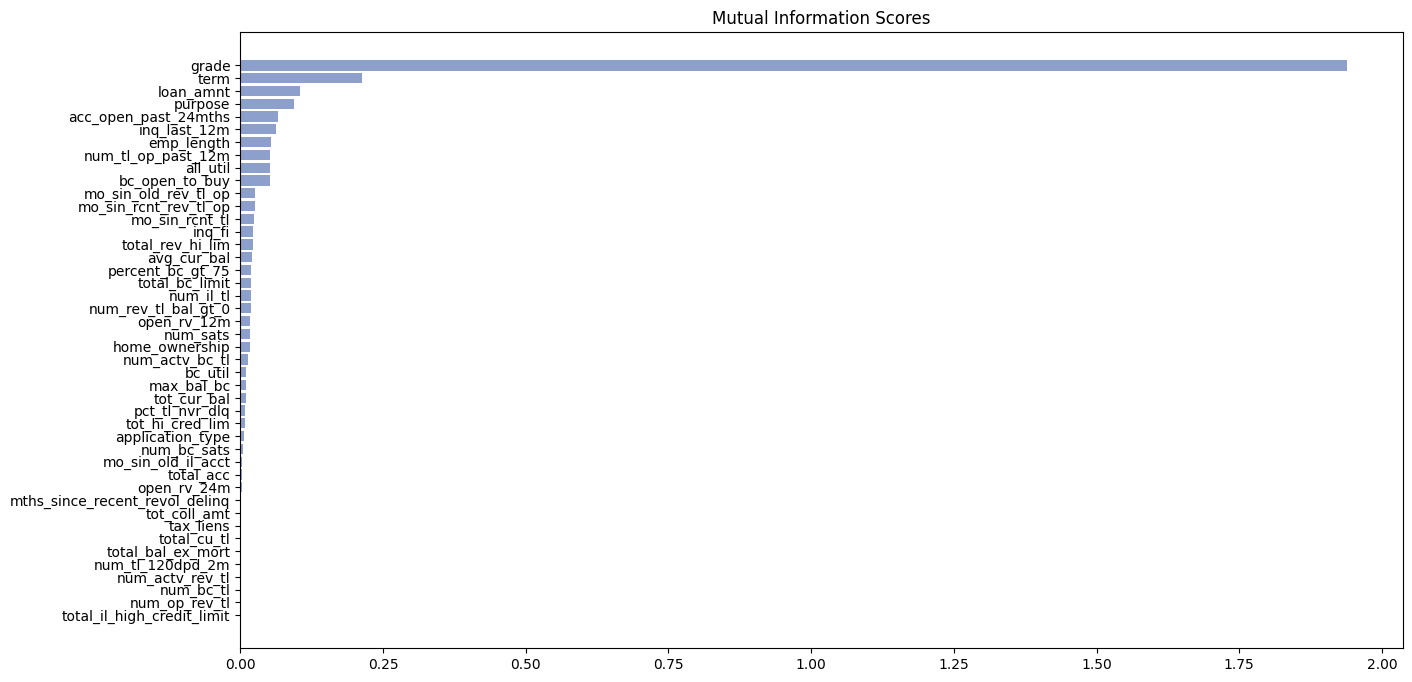

In [138]:
''' Getting mutal information values for numerical values '''
mi_scores = helpers.get_and_plot_mi_scores(df_accepted_step3[[col for col in df_accepted_step3.columns if col not in all_common_cols]].copy(),
                                           df_step3_targets, 'sub_grade')

In [139]:
''' Removing useless columns '''
df_accepted_step3 = df_accepted_step3[helpers.get_best_cols_from_mi_scores(mi_scores, df_accepted_step3, 0.01)]

##### MI scores for JOINT columns

Now I'll do the same for joint columns. We can see that fico range and dti values are the most important. But there are also a lot not useful columns, which I'll drop as well.

sec_app_fico_range_low       0.201129
sec_app_fico_range_high      0.172276
fico_range_high              0.164795
fico_range_low               0.154258
verification_status_joint    0.096850
verification_status          0.093926
dti_joint                    0.084823
dti                          0.032812
mort_acc                     0.030044
annual_inc                   0.014121
annual_inc_joint             0.010543
revol_bal                    0.000000
open_acc                     0.000000
revol_bal_joint              0.000000
sec_app_num_rev_accts        0.000000
sec_app_mort_acc             0.000000
sec_app_open_acc             0.000000
num_rev_accts                0.000000
Name: MI Scores, dtype: float64


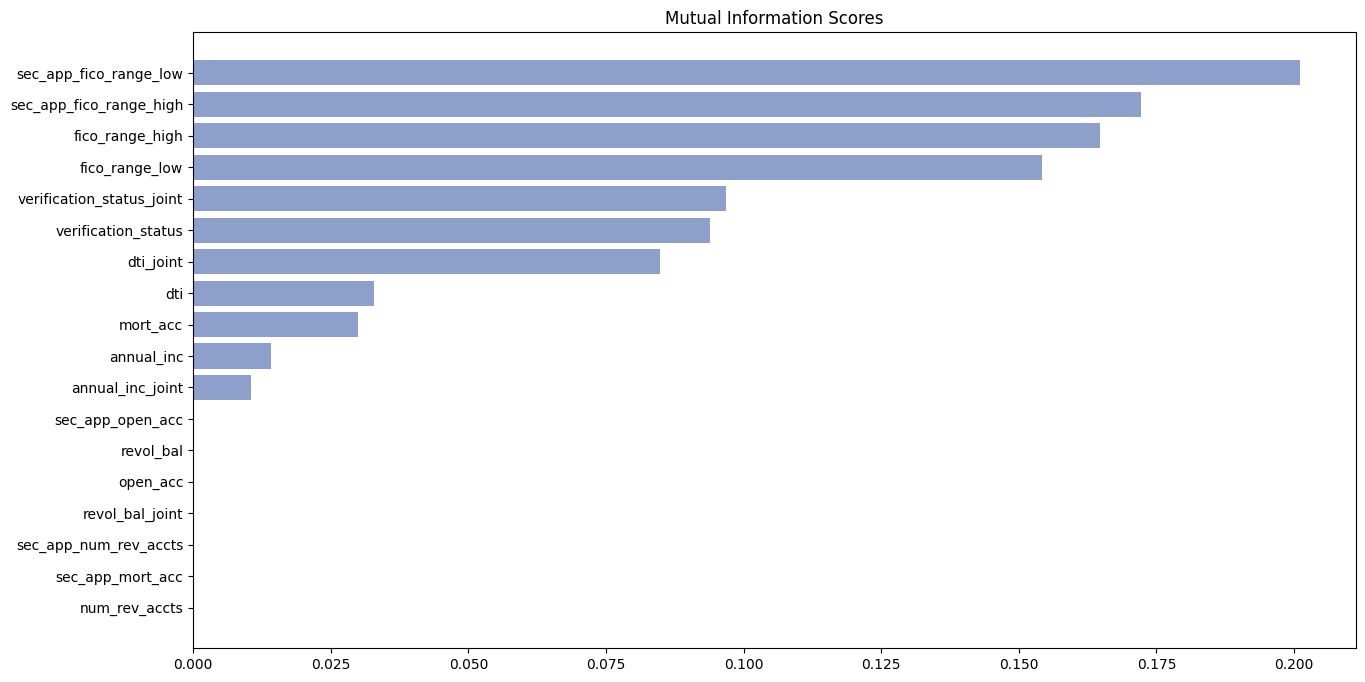

In [140]:
''' Getting mutal information values for numerical values '''
joint_mi_scores = helpers.get_and_plot_mi_scores(df_accepted_step3[all_common_cols].copy(),
                                                 df_step3_targets, 'sub_grade')

In [141]:
''' Getting columns to pdrop that have smaller than 0.01 mutual information score '''
useless_joint_cols = helpers.get_useless_joint_cols(joint_mi_scores, common_not_joint_cols, joint_cols, 0.01)

In [142]:
''' Dropping useless columns '''
df_accepted_step3 = df_accepted_step3.drop(useless_joint_cols, axis=1)

In [143]:
''' Taking features that are too correlated with one another '''
to_drop = helpers.get_too_correlated_cols_and_print_pairs(df_accepted_step3, all_common_cols, mi_scores)

There are no too correlated


##### Dropping too correlated columns

Now, I'll try to drop too correlated columns but we can see that actually there are none in this step as well.

In [144]:
''' Dropping too correlated columns '''
df_accepted_step3 = df_accepted_step3.drop(to_drop, axis=1)

##### Converting term and emp_length into ordinal values

Term and emp_length can be considered as ordinal values, therefore I'll convert them into numbers.

In [145]:
''' If term is not dropped, convert it to numerical value '''
if "term" in df_accepted_step3.columns:
    df_accepted_step3['term'] = df_accepted_step3['term'].map({" 36 months": 36, " 60 months": 60})

In [146]:
''' If emp_length is not dropped, convert it to numerical value '''
if "emp_length" in df_accepted_step3.columns:
    df_accepted_step3['emp_length'] = df_accepted_step3['emp_length'].map({"< 1 year": 0, "1 year": 1,
                                                                        "2 years": 2, "3 years": 3,
                                                                        "4 years": 4, "5 years": 5,
                                                                        "6 years": 6, "7 years": 7,
                                                                        "8 years": 8, "9 years": 9, "10+ years":10})

#### Creating New Features

In [147]:
''' Create a new column for the FICO score range average '''
df_accepted_step3['fico_avg'] = df_accepted_step3[['fico_range_high', 'fico_range_low']].apply(lambda x: x.mean(), axis=1)

In [148]:
''' Create a new column for the FICO Difference ''' 
df_accepted_step3['sec_app_fico_avg'] = df_accepted_step3[['sec_app_fico_range_high', 'sec_app_fico_range_low']].apply(lambda x: x.mean(), axis=1)

In [149]:
''' Create a new column for the FICO Difference ''' 
df_accepted_step3['fico_diff'] = df_accepted_step3['fico_range_high'] - df_accepted_step3['fico_range_low']

In [150]:
''' Create a new column for the FICO Difference ''' 
df_accepted_step3['sec_app_fico_diff'] = df_accepted_step3['sec_app_fico_range_high'] - df_accepted_step3['sec_app_fico_range_low']

In [151]:
'''Create a new column for the Loan Size Category '''
bins = [0, 5000, 10000, 20000, 30000, 40000, float('inf')]
labels = ['< 5K', '5K - 10K', '10K - 20K', '20K - 30K', '30K - 40K', '>= 40K']
df_accepted_step3['loan_size_category'] = pd.cut(df_accepted_step3['loan_amnt'], bins=bins, labels=labels)

In [152]:
''' Create a new column for the DTI category '''
bins = [0, 15, 25, float('inf')]
labels = ['DTI < 15%', '15% <= DTI <= 25%', 'DTI > 25%']
df_accepted_step3['DTI_Category'] = pd.cut(df_accepted_step3['dti'], bins=bins, labels=labels)

### Principal Component Analysis (PCA)

In [153]:
''' Taking joint columns into a list '''
joint_cols = set([col for col in df_accepted_step3.columns if "sec" in col or "joint" in col])
joint_num_cols = [col for col in joint_cols if df_accepted_step3[col].dtype != "object"]
joint_cat_cols = [col for col in joint_cols if df_accepted_step3[col].dtype == "object"]

In [154]:
''' Taking numerical and categorical features '''
numerical_features = df_accepted_step3.select_dtypes(include=[np.number]).columns.tolist() 
cat_features = df_accepted_step3.select_dtypes(include=['object', pd.api.types.CategoricalDtype]).columns.tolist()

In [155]:
''' Taking numerical, ordinal and other categorical values '''
num_cols = [col for col in numerical_features if col not in joint_cols]
ord_cols = [col for col in df_accepted_step3.columns if col in ['term', 'emp_length']]
ohec_cols = [col for col in df_accepted_step3.columns if col in cat_features and col not in ord_cols]

#### Train, test, validation sets

I'll split this data into train, test and validation by stratifying it with target value "sub_grade"

In [156]:
''' Splitting dataset into train and validation '''
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(df_accepted_step3, df_step3_targets, 'sub_grade')

In [157]:
''' Creating preprocessor and fitting on training data '''
preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy())
X_train_transformed = preprocessor.fit_transform(X_train)

Number of components to keep: 42


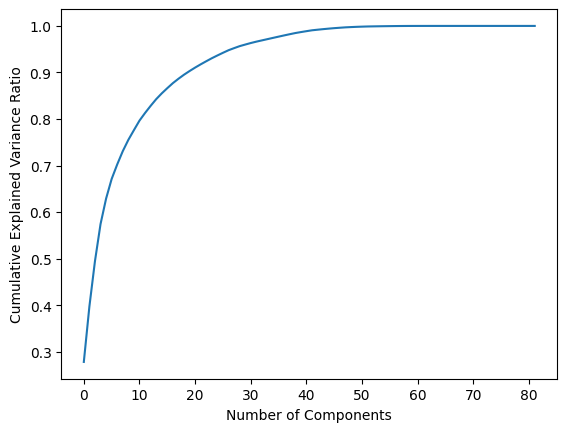

In [158]:
''' Plotting elbow plot and getting n_components '''
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.99)

In [159]:
''' Getting ipca value ''' 
_, ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.27806592 0.11907464 0.09738271 0.07961861 0.05484513 0.04220036
 0.03126494 0.02853013 0.02426853 0.02089229 0.02043957 0.01638779
 0.01526556 0.01441322 0.01242416 0.01125794 0.01077501 0.00937346
 0.00872058 0.00788503 0.00744413 0.00697833 0.00666211 0.00644714
 0.00593563 0.00574733 0.00550481 0.0044869  0.00426982 0.0034108
 0.00329496 0.00296629 0.00271134 0.00269439 0.00269032 0.0026713
 0.0026502  0.00256059 0.00249383 0.00206532 0.00195964 0.0018802 ]


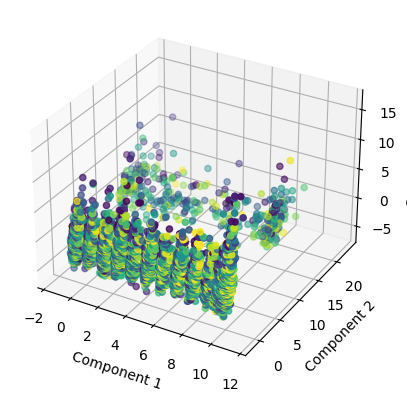

In [160]:
''' Plotting the 3 PCAs '''
helpers.plot_3_pcas(ipca, X_train_transformed, y_train)

In [161]:
''' Creating preprocessor and fitting on training data for tree based models '''
tree_preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy(), 'tree')
X_train_transformed = tree_preprocessor.fit_transform(X_train)

Number of components to keep: 31


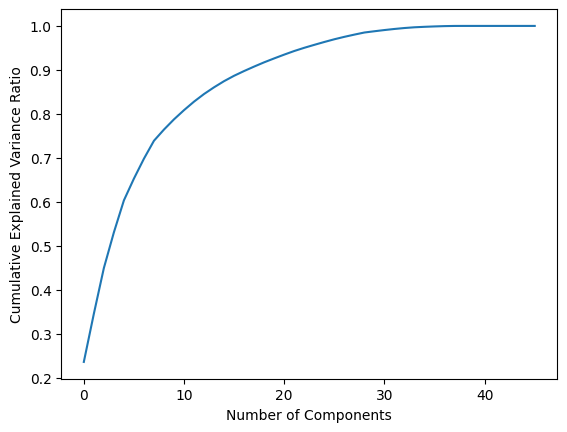

In [162]:
''' Plotting elbow plot and getting n_components'''
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.99)

In [163]:
''' Getting ipca value for tree based models '''
_, tree_ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.23582503 0.10945575 0.10400759 0.08122142 0.07273318 0.04952389
 0.04534765 0.04074337 0.02549744 0.02320187 0.0209105  0.01938393
 0.01733172 0.0152885  0.01395092 0.01225657 0.01076519 0.01013048
 0.00966788 0.00890331 0.00860687 0.00818677 0.00730317 0.00670985
 0.00650154 0.00617718 0.00554044 0.00506698 0.00476402 0.00286696
 0.00273475]


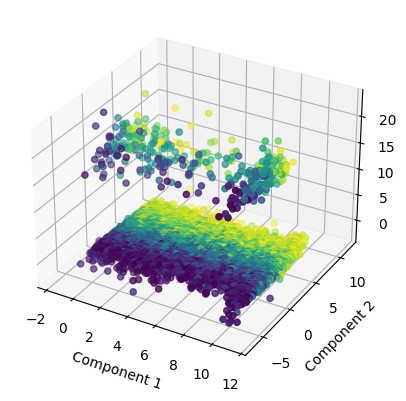

In [164]:
''' Plotting the 3 PCAs for tree '''
helpers.plot_3_pcas(tree_ipca, X_train_transformed, y_train)

### Sub Grade Prediction Part

In [165]:
''' Creating list of pipelines with preprocessor ''' 
pipelines = helpers.getting_pipelines(tree_models, tree_preprocessor, tree_ipca, other_models, preprocessor, ipca)

First, I run the models and we can see top 3 best models for predicting subgrade:

* **LogisticRegression** with f1 score of 0.23
* **BernoulliNB** with f1 score of 0.213
* **QuadraticDiscriminantAnalysis** with f1 score of 0.183

The f1 scores are not very high but maybe hyper parameter tuning might help with this.

In [166]:
''' Printing out results of tested models '''
print("The best performing models are:") 
models_results = helpers.try_models(pipelines, X_train, y_train, X_val, y_val)
models_results.iloc[:, 1:]

The best performing models are:


,model_name,f1_score,recall_score,precision_score
7,LogisticRegression,0.234029,0.238080,0.235987
10,BernoulliNB,0.211919,0.214085,0.212228
11,QuadraticDiscriminantAnalysis,0.185599,0.222499,0.222126
9,GaussianNB,0.167790,0.209099,0.213270
5,LGBMClassifier,0.166486,0.167030,0.167244
4,XGBClassifier,0.159230,0.160486,0.159633
0,RandomForestClassifier,0.157232,0.158305,0.158240
3,ExtraTreesClassifier,0.141028,0.143347,0.141170
1,GradientBoostingClassifier,0.134226,0.137114,0.133912
6,DecisionTreeClassifier,0.107062,0.107199,0.107450


Now I'll perform optuna tuning for these three models:

In [167]:
''' Perform optuna tuning '''
results = helpers.optuna_tuning(helpers.objective, models_results.head(3).copy(), X_train, y_train, X_val, y_val)

Tuned LogisticRegression:


,f1_score,penalty,C,solver
0,0.236024,l2,190.027749,saga


Tuned BernoulliNB:


,f1_score,alpha,fit_prior,binarize
0,0.223412,0.000619,False,0.223263


Tuned QuadraticDiscriminantAnalysis:


,f1_score,reg_param,tol,store_covariance
0,0.202798,0.037289,0.004121,False


In [168]:
''' Printing out top 3 models f1 scores '''
final_model_results = dict(sorted(results.items(), key=lambda item: item[1]['f1_score'], reverse=True))
dict(sorted({model[1]: result['f1_score'] for model, result in results.items()}.items(), key=lambda item: item[1], reverse=True))

{'LogisticRegression': 0.23602351185114087,
 'BernoulliNB': 0.22341224614238248,
 'QuadraticDiscriminantAnalysis': 0.202798206479779}

In [169]:
''' Getting list of final top 3 models '''
final_top_models = [pipeline[0] for pipeline in list(final_model_results.keys())]

**Cross Validation**

Now I'll perform cross validation to see how well our models are generalizing and how it behaves on new data compared with cross validated train data.

In [170]:
''' Getting predictions of top 3 models and performing cross validation '''
scores, predictions = helpers.perform_cross_validation(final_top_models, X_train, y_train, X_val, y_val, score='f1_score')

------------------------- LogisticRegression -------------------------
TRAIN DATA (cross validated) f1_score is 0.224
VALIDATION DATA - f1_score for the LogisticRegression model is: 0.236

------------------------- BernoulliNB -------------------------
TRAIN DATA (cross validated) f1_score is 0.218
VALIDATION DATA - f1_score for the BernoulliNB model is: 0.223

------------------------- QuadraticDiscriminantAnalysis -------------------------
TRAIN DATA (cross validated) f1_score is 0.193
VALIDATION DATA - f1_score for the QuadraticDiscriminantAnalysis model is: 0.203



We can see that after performing crossvalidation LogisticRegression and BernoulliNB are bahaving somewhat the same. Therefore, I will choose a model which has the best precision out of these two. But we can see the confusion matrices below, which can also show that those two models are quite similar, where QuadraticDiscriminantAnalysis is behaving way worse.

In [175]:
print(f"LogisticRegression precision value - {metrics.precision_score(y_val, list(predictions.values())[0], average='weighted')}")
print(f"BernoulliNB precision value - {metrics.precision_score(y_val, list(predictions.values())[1], average='weighted')}")

LogisticRegression precision value - 0.23796468821371192
BernoulliNB precision value - 0.22483549095029798


We can see that LogisticRegression have a higher precision score, therefore, I will choose this model over BernoulliNB.

This is a confusion matrix that shows the performance of a LogisticRegression model that predicts 35 different classes. The labels for the classes are A1, A2, A3...G3, G4, G5. The matrix is 35x35, and it is normalized.

Based on the confusion matrix, it appears that some classes are predicted better than others. Classes A1, A2, and A3 are predicted relatively well, with precision rates of 42%, 33%, and 21%, respectively. However, classes G3, G4, and G5 are predicted very poorly, with precision rates of 0%.

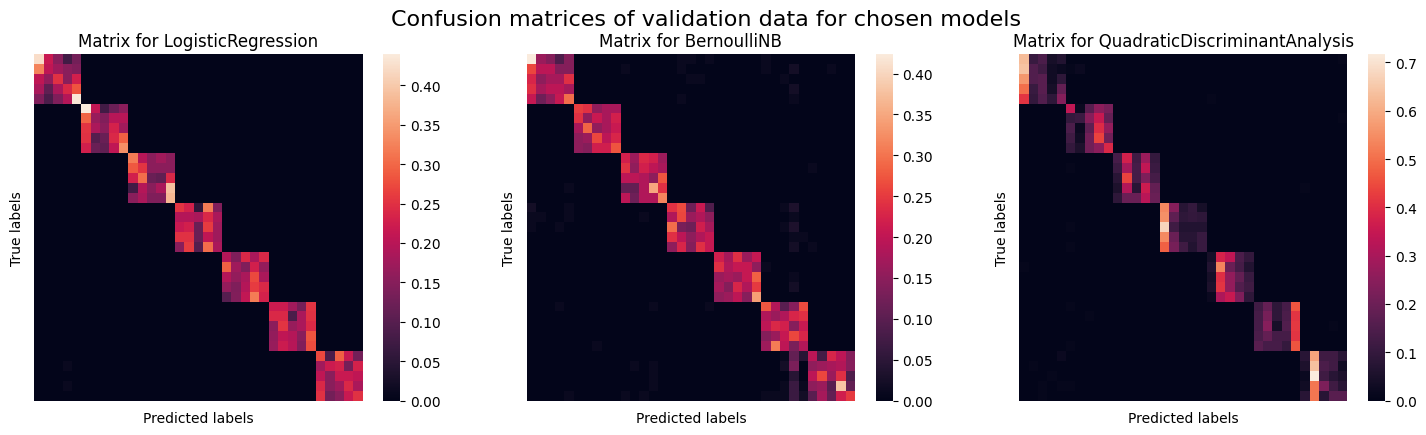

In [172]:
''' Plotting confusion matrices of top 3 models'''
helpers.plot_conf_matrices(predictions, y_val, annot=False)

In [173]:
''' Extracting the best model '''
best_model = list(predictions.keys())[0]
best_model.named_steps['model']

LogisticRegression(C=190.02774851451952, solver='saga')

In [181]:
''' Deploy model into pkl file '''
dump(best_model, "step3-subgrade_classifier.joblib")

['step3-subgrade_classifier.joblib']

## Go to next step - Step 4 - [Loan Interest Rate Prediction](https://github.com/TuringCollegeSubmissions/ebaran-ML1.3/blob/master/project%20notebooks%20(step1%2C%20step2%2C%20step2%20and%20step4)/Step4-Int_Rate.ipynb).